This notebook replicates the VGG16 LN + MNIST matching experiment in the paper "Git Re-Basin: Merging Models modulo Permutation Symmetries". It was found that a too small learning rate (lr = 0.001) in training was the reason for the failure.

In [ ]:
import sys
sys.path.append("..")

In [ ]:
import torch
from source.utils.utils import load_model, load_scheduler
from source.utils.data_funcs import load_data
from source.utils.weight_matching import weight_matching
from source.utils.activation_matching import activation_matching
from source.utils.connect import calculate_models_distance, eval_line
from source.utils.logger import Logger
from source.utils.train import train
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import numpy as np

In [ ]:
class config:
    model = 'cifar_vgg16_ln'
    dataset = 'mnist'
    special_init = None # 'vgg_init' (kaiming init) or None (uniform init)
    print_freq = 100
    data_dir = '../../Linear_Mode_Connectivity/data'
    n = 3 # number of interpolation points
    n_epochs = 25
    scheduler = 'linear_cosine'
    warmup_iters = 60000 // 128 + 1
    decay_iters = warmup_iters * (n_epochs-1)

In [ ]:
# necessary to create logger if using the train/validate/eval_line etc. functions
Logger.setup_logging()
logger = Logger()

import torchvision
from torchvision import transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.1307,), (0.3081,))
    ])

trainset = torchvision.datasets.MNIST(
    config.data_dir, train=True, download=True,
    transform=transform)
testset = torchvision.datasets.MNIST(
    config.data_dir, train=False, download=True,
    transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
os.mkdir('../vgg16_ln_mnist/lr_0.1')
os.mkdir('../vgg16_ln_mnist/lr_0.01')
os.mkdir('../vgg16_ln_mnist/lr_0.001')

In [ ]:
for lr in [0.001, 0.01, 0.1]:
    model_1 = load_model(config).to(device)
    model_2 = load_model(config).to(device)
    optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler_1 = load_scheduler(optimizer_1, config)
    scheduler_2 = load_scheduler(optimizer_2, config)

    loss_s = [[], []]
    acc_s = [[], []]
    distance_s = [] 

    for epoch in range(config.n_epochs):
        loss_1, acc_1, _, _ = train(trainloader, model_1, criterion, optimizer_1, epoch, device, config, scheduler_1)
        loss_2, acc_2, _, _ = train(trainloader, model_2, criterion, optimizer_2, epoch, device, config, scheduler_2)
        distance = calculate_models_distance(model_1, model_2)
        distance_s.append(distance)
        loss_s[0].append(loss_1)
        loss_s[1].append(loss_2)
        acc_s[0].append(acc_1)
        acc_s[1].append(acc_2)

    torch.save(model_1.state_dict(), f'../vgg16_ln_mnist/lr_{lr}/model_1_{config.n_epochs}.pt')
    torch.save(model_2.state_dict(), f'../vgg16_ln_mnist/lr_{lr}/model_2_{config.n_epochs}.pt')

In [ ]:
sd_1 = torch.load('../vgg16_ln_mnist/lr_0.1/model_1_25.pt')
sd_2 = torch.load('../vgg16_ln_mnist/lr_0.1/model_2_25.pt')
sd_3 = torch.load('../vgg16_ln_mnist/lr_0.01/model_1_25.pt')
sd_4 = torch.load('../vgg16_ln_mnist/lr_0.01/model_2_25.pt')
sd_5 = torch.load('../vgg16_ln_mnist/lr_0.001/model_1_25.pt')
sd_6 = torch.load('../vgg16_ln_mnist/lr_0.001/model_2_25.pt')

model_1, model_2 = load_model(config).to(device), load_model(config).to(device)
model_3, model_4 = load_model(config).to(device), load_model(config).to(device)
model_5, model_6 = load_model(config).to(device), load_model(config).to(device)
model_1.load_state_dict(sd_1)
model_2.load_state_dict(sd_2)
model_3.load_state_dict(sd_3)
model_4.load_state_dict(sd_4)
model_5.load_state_dict(sd_5)
model_6.load_state_dict(sd_6)

sd_2_wm, _ = weight_matching(config.model, sd_1, sd_2, device=device)
sd_4_wm, _ = weight_matching(config.model, sd_3, sd_4, device=device)
sd_6_wm, _ = weight_matching(config.model, sd_5, sd_6, device=device)

model_2_wm = load_model(config).to(device)
model_2_wm.load_state_dict(sd_2_wm)
model_4_wm = load_model(config).to(device)
model_4_wm.load_state_dict(sd_4_wm)
model_6_wm = load_model(config).to(device)
model_6_wm.load_state_dict(sd_6_wm)

lmc_test_1_wm = eval_line(model_1, model_2_wm, testloader, criterion, device, config, n=config.n)
lmc_test_2_wm = eval_line(model_3, model_4_wm, testloader, criterion, device, config, n=config.n)
lmc_test_3_wm = eval_line(model_5, model_6_wm, testloader, criterion, device, config, n=config.n)

sd_2_am, _ = activation_matching(config.model, model_1, model_2, trainloader, 100, device)
sd_4_am, _ = activation_matching(config.model, model_3, model_4, trainloader, 100, device)
sd_6_am, _ = activation_matching(config.model, model_5, model_6, trainloader, 100, device)

model_2_am = load_model(config).to(device)
model_2_am.load_state_dict(sd_2_am)
model_4_am = load_model(config).to(device)
model_4_am.load_state_dict(sd_4_am)
model_6_am = load_model(config).to(device)
model_6_am.load_state_dict(sd_6_am)

lmc_test_1_am = eval_line(model_1, model_2_am, testloader, criterion, device, config, n=config.n)
lmc_test_2_am = eval_line(model_3, model_4_am, testloader, criterion, device, config, n=config.n)
lmc_test_3_am = eval_line(model_5, model_6_am, testloader, criterion, device, config, n=config.n)

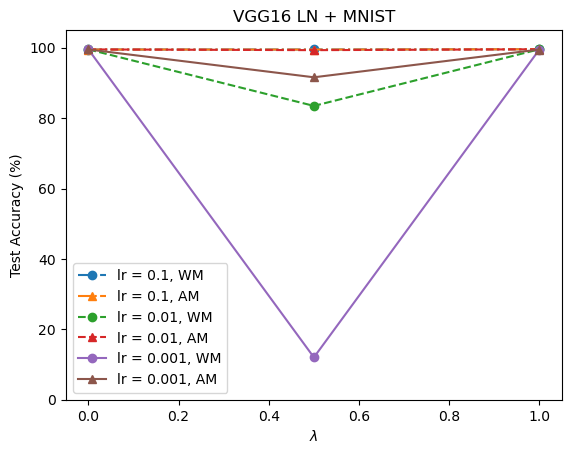

In [7]:
x_axis = np.linspace(0, 1, config.n)

train = 'test'
metric = 'acc'
idx = 0 if metric == 'loss' else 1

plt.errorbar(x_axis, lmc_test_1_wm[:, idx], label='lr = 0.1, WM', linestyle='-.', marker='o')
plt.errorbar(x_axis, lmc_test_1_am[:, idx], label='lr = 0.1, AM', linestyle='-.', marker='^')
plt.errorbar(x_axis, lmc_test_2_wm[:, idx], label='lr = 0.01, WM', linestyle='--', marker='o')
plt.errorbar(x_axis, lmc_test_2_am[:, idx], label='lr = 0.01, AM', linestyle='--', marker='^')
plt.errorbar(x_axis, lmc_test_3_wm[:, idx], label='lr = 0.001, WM', marker='o')
plt.errorbar(x_axis, lmc_test_3_am[:, idx], label='lr = 0.001, AM', marker='^')
plt.title('VGG16 LN + MNIST')

if metric == 'loss':
    if train == 'train':
        plt.ylabel('Training Loss')
    if train == 'test':
        plt.ylabel('Test Loss')
elif metric == 'acc':
    if train == 'train':
        plt.ylabel('Training Accuracy (%)')
    if train == 'test':
        plt.ylabel('Test Accuracy (%)')
    plt.ylim(0, 105)

plt.xlabel(r'$\lambda$')
plt.legend()